## Cloth Classification Task
8 classes

In [1]:
import os
import torch
import time
import copy
import math
import pandas as pd
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Visualize Data

In [2]:
train_frame = pd.read_csv('./data/train label.csv')

# check one photo
img_name = train_frame.iloc[7, 0]
classes = train_frame.iloc[:, 1].as_matrix()
classes = classes.astype('float').reshape(-1, 1)

print('Image name: {}'.format(img_name))
print('classes shape: {}'.format(classes.shape))
print('classes: {}'.format(classes[7]))

Image name: 1002906763_0.jpg
classes shape: (21048, 1)
classes: [ 0.]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


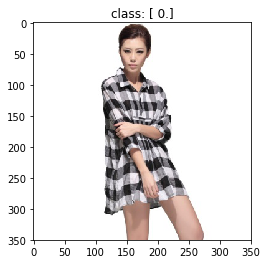

In [3]:
# show images
def show_image(images, label):
    plt.title('class: {}'.format(label))
    plt.imshow(images)
    
show_image(io.imread(os.path.join('./data/image/train/', img_name)), classes[7])

## Construct Dataset

In [4]:
class ClothDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, test=False):
        self.train_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.test = test
        
        if self.test:
            imgs = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]
        else:
            names = self.train_frame.iloc[:, 0]
            imgs = [os.path.join(root_dir, img) for img in names]
    
        self.imgs = imgs
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        if self.test == False:
            label = self.train_frame.iloc[idx, 1]
        else:
            label = -1
            
        image = Image.open(img_path)
        image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
            
        return image, label

### Check Dataset(train)

0 0
1 0
2 0
3 0


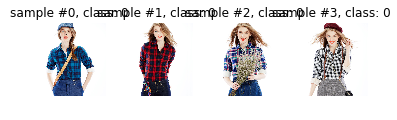

In [5]:
cloth_train_dataset = ClothDataset(csv_file='./data/train label.csv', root_dir='./data/image/train/', test=False)
fig = plt.figure()

for i in range(len(cloth_train_dataset)):
    image, label = cloth_train_dataset[i]
    
    print(i, label)
    
    ax = plt.subplot(1, 4, i + 1)
    
    ax.set_title('sample #{}, class: {}'.format(i, label))
    ax.axis('off')
    plt.imshow(image)
    
    if i == 3:
        plt.show()
        break

### Check Dataset(test)

In [6]:
cloth_test_dataset = ClothDataset(csv_file='./data/train label.csv', root_dir='./data/image/test/', test=True)
fig = plt.figure()

for i in range(len(cloth_test_dataset)):
    image, label = cloth_test_dataset[i]
    
    print(i, label)
    
    ax = plt.subplot(1, 4, i + 1)
    
    ax.set_title('sample #{}, class: {}'.format(i, label))
    ax.axis('off')
    plt.imshow(image)
    
    if i == 3:
        plt.show()
        break

0 -1
1 -1
2 -1
3 -1


### Data Augmentation

In [7]:
# transform1
transform_train = transforms.Compose([
    transforms.Resize((350, 350)),
    # transforms.CenterCrop(350),
    #transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# transform2
transform_test = transforms.Compose([
    transforms.Resize((350,350)),
    # transforms.CenterCrop(350),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Test Transformation

<class 'tuple'>
train_dataset size:  21048
0 torch.Size([3, 350, 350]) 0
1 torch.Size([3, 350, 350]) 0
2 torch.Size([3, 350, 350]) 0
3 torch.Size([3, 350, 350]) 0


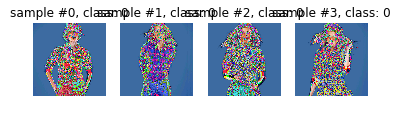

In [8]:
full_dataset = ClothDataset(csv_file='./data/train label.csv', root_dir='./data/image/train/', test=False, transform=transform_train)
print(type(full_dataset[i]))
print('train_dataset size: ', len(full_dataset))

fig = plt.figure()
for i in range(len(full_dataset)):
    image, label = full_dataset[i]
    print(i, image.shape ,label)
    
    ax = plt.subplot(1, 4, i + 1)
    
    ax.set_title('sample #{}, class: {}'.format(i, label))
    ax.axis('off')
    image = transforms.ToPILImage()(image).convert('RGB')
    plt.imshow(image)
    
    if i == 3:
        break

## 划分训练集和校验集

In [9]:
validation_split=0.2
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Create data samples and loaders
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=20, sampler=train_sampler)
validation_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=20, sampler=valid_sampler)

print(type(train_dataloader))
print(type(validation_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [10]:
# combine train and validation into one dict
dataloaders = {'train': train_dataloader, 'val': validation_dataloader}
dataset_sizes = {'train': len(train_indices), 'val': len(val_indices)}
print(dataset_sizes['train'])

16839


<class 'tuple'>
0 torch.Size([3, 350, 350]) -1
1 torch.Size([3, 350, 350]) -1
2 torch.Size([3, 350, 350]) -1
3 torch.Size([3, 350, 350]) -1


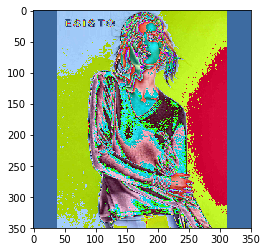

In [11]:
test_dataset = ClothDataset(csv_file='./data/train label.csv', root_dir = './data/image/test/', test=True,transform= transform_test)
print(type(test_dataset[i]))

for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    
    print(i, image.size(), label)
    image = transforms.ToPILImage()(image).convert('RGB')
    plt.imshow(image)
    if i == 3:
        break

### Show Batch Data

<class 'torch.utils.data.dataloader.DataLoader'>
0 torch.Size([20, 3, 350, 350]) tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1])
1 torch.Size([20, 3, 350, 350]) tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 torch.Size([20, 3, 350, 350]) tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1])
3 torch.Size([20, 3, 350, 350]) tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1])


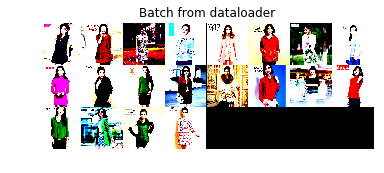

In [12]:
# use DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False)
print(type(test_dataloader))


def show_cloth_batch(images_batch, labels_batch):
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):
        plt.title('Batch from dataloader')
        
for i_batch, (images_batch, labels_batch) in enumerate(test_dataloader):
    print(i_batch, images_batch.size(), labels_batch)
    
    if i_batch == 3:
        plt.figure()
        show_cloth_batch(images_batch, labels_batch)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Train Model

In [13]:
def show_curve(ys, title):
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y)
    plt.title("{} curve".format(title))
    plt.xlabel('epoch')
    plt.ylabel("{}".format(title))
    plt.show()

In [14]:
def save_model(model,filename):
    state = model.state_dict()
    for key in state: state[key] = state[key].clone().cpu()
    torch.save(state, filename)

In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    # measure time
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and testing phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() # train mode
            else:
                model.eval() # evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over data
            for i_batch, (images_batch, labels_batch) in enumerate(dataloaders[phase]):
                #print(type(sample_batched['image']))
                #print(type(sample_batched['has_cactus']))
                
                inputs = images_batch.to(device, dtype=torch.float)
                labels = labels_batch.to(device, dtype=torch.long)
                
                # labels = labels.resize(labels.size()[0])
                #print(labels.size())
                #print(labels)
                
                # zero gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #print(outputs.size())
                    #print(labels.size())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistic
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            #print(running_loss)
            #print(running_corrects)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # save best model weights up-to-date
                save_model(model, './model/resnet50_adam_350_15_BEST.pt')
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    show_curve(train_loss, 'train_loss')
    show_curve(train_acc, 'train_acc')
    show_curve(val_loss, 'val_loss')
    show_curve(val_acc, 'val_acc')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualize Model Prediction

In [30]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [31]:
# Visualize the model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i_batch, (images_batch, labels_batch) in enumerate(dataloaders['val']):
            # Move to GPU
            inputs = images_batch.to(device, dtype=torch.float)
            labels = labels_batch.to(device, dtype=torch.long)
            # labels = labels.resize(labels.size()[0])
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                # show images
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predict: {}'.format(preds[j].item()))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            model.train(mode=was_training)

## Set Hyper-parameter

In [32]:
# Set Model
model_resnet50 = models.resnet50(pretrained=True)
model_resnet50.fc = nn.Linear(51200, 8)

# Set Parameters
lr = 0.0001
momentum = 0.9
step_size=5
gamma=0.1
num_epochs=15

# Set GPU
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:2


### resnet50(pretrained)

In [33]:
model = model_resnet50.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Epoch 0/14
----------
train Loss: 0.6027 Acc: 0.8006
val Loss: 0.3988 Acc: 0.8634

Epoch 1/14
----------
train Loss: 0.3611 Acc: 0.8818
val Loss: 0.4118 Acc: 0.8589

Epoch 2/14
----------
train Loss: 0.2755 Acc: 0.9088
val Loss: 0.3830 Acc: 0.8724

Epoch 3/14
----------
train Loss: 0.2188 Acc: 0.9263
val Loss: 0.4566 Acc: 0.8617

Epoch 4/14
----------
train Loss: 0.1839 Acc: 0.9371
val Loss: 0.4750 Acc: 0.8636

Epoch 5/14
----------
train Loss: 0.0708 Acc: 0.9786
val Loss: 0.3684 Acc: 0.9012

Epoch 6/14
----------
train Loss: 0.0405 Acc: 0.9878
val Loss: 0.4044 Acc: 0.9000

Epoch 7/14
----------
train Loss: 0.0240 Acc: 0.9938
val Loss: 0.4528 Acc: 0.9007

Epoch 8/14
----------
train Loss: 0.0172 Acc: 0.9957
val Loss: 0.5144 Acc: 0.8947

Epoch 9/14
----------
train Loss: 0.0147 Acc: 0.9964
val Loss: 0.5094 Acc: 0.8936

Epoch 10/14
----------
train Loss: 0.0108 Acc: 0.9973
val Loss: 0.5042 Acc: 0.8969

Epoch 11/14
----------
train Loss: 0.0086 Acc: 0.9981
val Loss: 0.5162 Acc: 0.8990

Ep

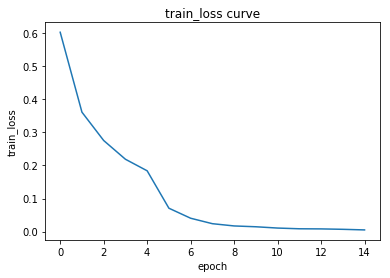

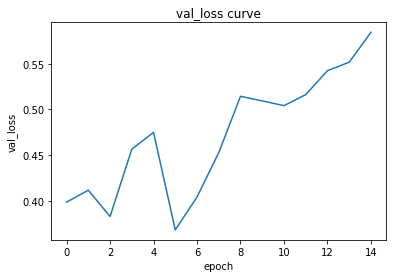

In [34]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

### resnet50(pretrained) __ epoch=25

In [18]:
# Set Model
model_resnet50 = models.resnet50(pretrained=True)
model_resnet50.fc = nn.Linear(51200, 8)

# Set Parameters
lr = 0.0001
momentum = 0.9
step_size=5
gamma=0.1
num_epochs=25

# Set GPU
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:2


In [19]:
model = model_resnet50.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Epoch 0/24
----------
train Loss: 0.5927 Acc: 0.8025
val Loss: 0.3923 Acc: 0.8686

Epoch 1/24
----------
train Loss: 0.3552 Acc: 0.8856
val Loss: 0.4632 Acc: 0.8382

Epoch 2/24
----------
train Loss: 0.2731 Acc: 0.9078
val Loss: 0.4887 Acc: 0.8494

Epoch 3/24
----------
train Loss: 0.2223 Acc: 0.9262
val Loss: 0.3903 Acc: 0.8807

Epoch 4/24
----------
train Loss: 0.1856 Acc: 0.9387
val Loss: 0.4287 Acc: 0.8774

Epoch 5/24
----------
train Loss: 0.0729 Acc: 0.9765
val Loss: 0.3672 Acc: 0.8959

Epoch 6/24
----------
train Loss: 0.0402 Acc: 0.9879
val Loss: 0.4130 Acc: 0.8967

Epoch 7/24
----------
train Loss: 0.0283 Acc: 0.9913
val Loss: 0.4472 Acc: 0.8955

Epoch 8/24
----------
train Loss: 0.0199 Acc: 0.9939
val Loss: 0.4566 Acc: 0.8981

Epoch 9/24
----------
train Loss: 0.0128 Acc: 0.9961
val Loss: 0.5387 Acc: 0.8969

Epoch 10/24
----------
train Loss: 0.0106 Acc: 0.9975
val Loss: 0.5211 Acc: 0.9005

Epoch 11/24
----------
train Loss: 0.0087 Acc: 0.9981
val Loss: 0.5279 Acc: 0.9007

Ep

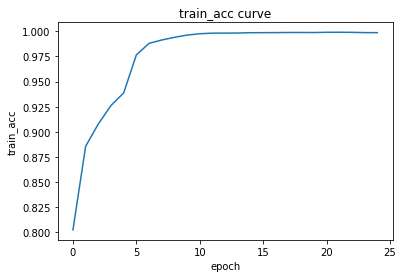

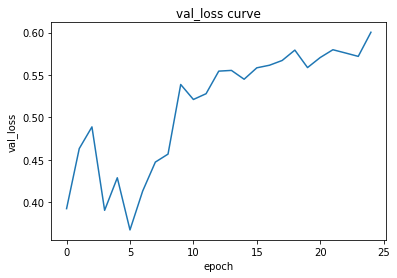

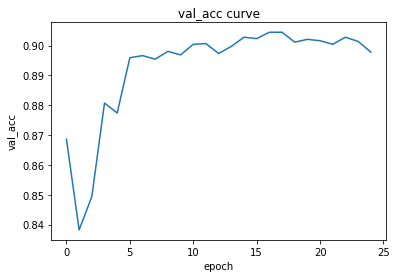

In [20]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

## Predict

In [21]:
def predict(model, test_dataloader):
    result = []
    with torch.no_grad():
         for i_batch, (images_batch, labels_batch) in enumerate(test_dataloader):
            # Move to GPU
            inputs = images_batch.to(device, dtype=torch.float)
            labels = labels_batch.to(device, dtype=torch.long)
            # labels = labels.resize(labels.size()[0])
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            
            # print(type(preds))
            # print(preds)
            preds_np = preds.cpu().numpy()
            # print(preds_np)
            result = np.append(result, preds_np)
            
            # print(result)
            
            if (i_batch == 2000):
                print('2000 batches')
            elif i_batch == 4000:
                print('4000 batches')
    
    return result

In [23]:
# Set Model
model_resnet50 = models.resnet50(pretrained=True)
model_resnet50.fc = nn.Linear(51200, 8)

checkpoint = torch.load('./model/resnet50_adam_350_25_BEST.pt')
model_resnet50.load_state_dict(checkpoint)

# Set GPU
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)
model = model_resnet50.to(device)

cuda:2


In [24]:
result = predict(model, test_dataloader)

In [25]:
print(type(result))
print(result.shape)

<class 'numpy.ndarray'>
(4500,)


In [26]:
img_idx = os.listdir('./data/image/test/')
print(img_idx)
img_idx = prediction.iloc[:, 0]
print(img_idx)

['1257194670_0.jpg', '1331669067_0.jpg', '1030031690_0.jpg', '1042079939_0.jpg', '1392549927_0.jpg', '1219369112_0.jpg', '1074414124_0.jpg', '1022435684_0.jpg', '1382318481_0.jpg', '1109736123_0.jpg', '1049622193_0.jpg', '1029862130_0.jpg', '1445565607_0.jpg', '1454956234_0.jpg', '1004558638_0.jpg', '1477572864_0.jpg', '1797314050_0.jpg', '1054664399_0.jpg', '1087983100_0.jpg', '1156694115_0.jpg', '1187166366_0.jpg', '1344869062_0.jpg', '1411108444_0.jpg', '1500368012_0.jpg', '1111112171_0.jpg', '1166941378_0.jpg', '1246367092_0.jpg', '1350177495_0.jpg', '10056013380_0.jpg', '1121574657_0.jpg', '1303850620_0.jpg', '1102712669_0.jpg', '1205757170_0.jpg', '1036523237_0.jpg', '1324702294_0.jpg', '1392129959_0.jpg', '1359907332_0.jpg', '1478486268_0.jpg', '1389461157_0.jpg', '1095502819_0.jpg', '1722904135_0.jpg', '1029194300_0.jpg', '1539907962_0.jpg', '1409573292_0.jpg', '1485571905_0.jpg', '1146838255_0.jpg', '1101318621_0.jpg', '1314149812_0.jpg', '1146567724_0.jpg', '1262301524_0.jpg'

NameError: name 'prediction' is not defined

In [27]:
classify_result = pd.DataFrame({'Image': img_idx, 'Cloth_label': result.astype(np.int32)})
print(classify_result)

                  Image  Cloth_label
0      1257194670_0.jpg            2
1      1331669067_0.jpg            6
2      1030031690_0.jpg            0
3      1042079939_0.jpg            7
4      1392549927_0.jpg            3
5      1219369112_0.jpg            7
6      1074414124_0.jpg            7
7      1022435684_0.jpg            5
8      1382318481_0.jpg            7
9      1109736123_0.jpg            5
10     1049622193_0.jpg            3
11     1029862130_0.jpg            2
12     1445565607_0.jpg            4
13     1454956234_0.jpg            3
14     1004558638_0.jpg            1
15     1477572864_0.jpg            4
16     1797314050_0.jpg            0
17     1054664399_0.jpg            5
18     1087983100_0.jpg            4
19     1156694115_0.jpg            5
20     1187166366_0.jpg            3
21     1344869062_0.jpg            3
22     1411108444_0.jpg            3
23     1500368012_0.jpg            7
24     1111112171_0.jpg            1
25     1166941378_0.jpg            1
2

In [28]:
classify_result.to_csv('./result/result_resnet50_350_25_new_0706.csv', index=False)